In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
import numpy as np
import scipy.io
from typing import List, Dict
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from prettytable import PrettyTable

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# ------------------------- Model ------------------------- #
class ResidualBlock(nn.Module):
    def __init__(self, dim, use_residual=True):
        super().__init__()
        self.use_residual = use_residual

        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Tanh(),
            nn.Linear(dim, dim)
        )

    def forward(self, x):
        out = self.block(x)
        if self.use_residual:
            return x + out
        else:
            return out

class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks, use_residual=True):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.blocks = nn.Sequential(*[
            ResidualBlock(hidden_dim, use_residual) for _ in range(num_blocks)
        ])
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.tanh(self.input_layer(x))
        x = self.blocks(x)
        return self.output_layer(x)

# ------------------------- Gradients ------------------------- #
def gradient(y: torch.Tensor, inputs: List[torch.Tensor]) -> List[torch.Tensor]:
    grads = torch.autograd.grad(
        outputs=y,
        inputs=inputs,
        grad_outputs=torch.ones_like(y),
        create_graph=True,
        retain_graph=True,
        allow_unused=True
    )
    return list(grads)

# ------------------------- PDE Residual ------------------------- #
def pde_fn(outputs: Dict[str, torch.Tensor], x: torch.Tensor, t: torch.Tensor) -> Dict[str, torch.Tensor]:
    u = outputs["u"]
    v = outputs["v"]

    u_x, u_t = gradient(u, [x, t])
    v_x, v_t = gradient(v, [x, t])

    u_xx = gradient(u_x, [x])[0]
    v_xx = gradient(v_x, [x])[0]

    abs_sq = u ** 2 + v ** 2

    outputs["f_u"] = u_t + 0.5 * v_xx + abs_sq * v
    outputs["f_v"] = v_t - 0.5 * u_xx - abs_sq * u

    return outputs

# ------------------------- Load Data ------------------------- #
def load_data():
    data = scipy.io.loadmat("data/NLS.mat")
    x = data["x"].flatten()           # (256,)
    t = data["tt"].flatten()          # (201,)
    u = np.real(data["uu"])           # (256, 201)
    v = np.imag(data["uu"])           # (256, 201)

    data.update({'u': u, 'v': v})

    X, T = np.meshgrid(x, t, indexing="ij")  # shape (256, 201)

    XT = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))   # [N, 2]
    U = np.hstack((u.flatten()[:, None], v.flatten()[:, None]))    # [N, 2]

    return torch.tensor(XT, dtype=torch.float32), torch.tensor(U, dtype=torch.float32), data

# ------------------------- Losses ------------------------- #
def pde_loss(model, x_f):
    x = x_f[:, 0:1].clone().detach().requires_grad_(True)
    t = x_f[:, 1:2].clone().detach().requires_grad_(True)

    xt = torch.cat([x, t], dim=1)
    pred = model(xt)

    outputs = {"u": pred[:, 0:1], "v": pred[:, 1:2]}
    outputs = pde_fn(outputs, x, t)

    return torch.mean(outputs["f_u"] ** 2 + outputs["f_v"] ** 2)

def data_loss(model, x_u, u_gt):
    pred = model(x_u)
    return torch.mean((pred - u_gt) ** 2)



def boundary_loss(model, t_f):
    # Assumes t_f is of shape (N, 2) with columns [x, t] but x is ignored here
    t = t_f[:, 1:2].clone().detach().requires_grad_(True)

    x_left = torch.full_like(t, -5.0)
    x_right = torch.full_like(t, 5.0)

    xt_left = torch.cat([x_left, t], dim=1).to(t.device).requires_grad_(True)
    xt_right = torch.cat([x_right, t], dim=1).to(t.device).requires_grad_(True)

    uv_left = model(xt_left)
    uv_right = model(xt_right)

    u_l, v_l = uv_left[:, 0:1], uv_left[:, 1:2]
    u_r, v_r = uv_right[:, 0:1], uv_right[:, 1:2]

    # Magnitude h = sqrt(u^2 + v^2)
    h_l = torch.sqrt(u_l ** 2 + v_l ** 2)
    h_r = torch.sqrt(u_r ** 2 + v_r ** 2)

    # Compute gradients ∂h/∂x
    h_x_l = gradient(h_l, [xt_left])[0]
    h_x_r = gradient(h_r, [xt_right])[0]

    loss_h = torch.mean((h_l - h_r) ** 2)
    loss_hx = torch.mean((h_x_l - h_x_r) ** 2)

    return loss_h + loss_hx

In [4]:
def count_parameters(model):
    # Source: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params


# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

def evaluate_mse(model, data):
    x = data["x"].flatten()
    t = data["tt"].flatten()
    X, T = np.meshgrid(x, t, indexing="ij")

    XT = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    XT_tensor = torch.tensor(XT, dtype=torch.float32).to(device)

    with torch.no_grad():
        pred = model(XT_tensor)
        u_pred = pred[:, 0].cpu().numpy().reshape(X.shape)
        v_pred = pred[:, 1].cpu().numpy().reshape(X.shape)

    u_true = data["u"]
    v_true = data["v"]

    mse_u = np.mean((u_pred - u_true) ** 2)
    mse_v = np.mean((v_pred - v_true) ** 2)

    return mse_u, mse_v
    # print(f"Validation MSE - u: {mse_u:.6e}, v: {mse_v:.6e}, total: {(mse_u + mse_v):.6e}")




In [5]:
# ------------------------- Training ------------------------- #
def train(max_epochs=1000):


    loss_ic_log = np.empty(max_epochs)
    loss_pde_log = np.empty(max_epochs)
    loss_val_log = np.empty(max_epochs)

    XT, UV, data = load_data()

    # Split initial and boundary data
    x = XT[:, 0]
    t = XT[:, 1]

    # Initial condition (t=0)
    t0_mask = (t == 0)
    XT_0 = XT[t0_mask].to(device)
    UV_0 = UV[t0_mask].to(device)

    N_ic = 50
    idx_ic = torch.randperm(XT_0.shape[0])[:N_ic]
    x0 = XT_0[idx_ic].to(device)
    u0 = UV_0[idx_ic].to(device)

    print(f"Input dim= {x0.shape}")

    # x_bc_mask = (XT[:, 0] == torch.min(XT[:, 0])) | (XT[:, 0] == torch.max(XT[:, 0]))
    # XT_bc = XT[x_bc_mask]
    #
    # print(f"{torch.max(XT[:, 0])}")


    # N_bc = 20
    # idx_bc = torch.randperm(XT_bc.shape[0])[:N_bc]
    # t_bc = XT_bc[idx_bc].to(device)
    # print(f"t_bc= {t_bc}")

    # Collocation points (residual enforcement)
    N_f = 20_000
    idx_f = torch.randperm(XT.shape[0])[:N_f]
    X_f = XT[idx_f].to(device)

    # Model + optimizer
    # model = PINN(in_dim=2, out_dim=2, width=64, depth=4)
    model = PINN(input_dim=2, hidden_dim=100, output_dim=2, num_blocks=2, use_residual=False).to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


    optimizer = torch.optim.LBFGS(model.parameters(), lr=1, max_iter=1)
    # Beat State-of-the-Art: [00299] loss= 4.3018e-05 | ic= 3.4003e-06 | pde= 3.9617e-05 | valid= 6.8350e-04
    # lr= 1, max_iter= 20

    # optimizer = torch.optim.LBFGS(
    #                         model.parameters(),
    #                         lr=0.5,
    #                         max_iter=30,
    #                         history_size=20,
    #                         line_search_fn="strong_wolfe"
    #                     )

    def closure():
        optimizer.zero_grad()

        loss_u = data_loss(model, x0, u0)
        # loss_bc = boundary_loss(model, t_bc)
        loss_f = pde_loss(model, X_f)
        loss = loss_u + loss_f

        loss.backward()
        return loss

    count_parameters(model)

    # Training loop
    for epoch in range(max_epochs):
        optimizer.zero_grad()

        loss_data = data_loss(model, x0, u0)
        # loss_bc = boundary_loss(model, t_bc)
        loss_phys = pde_loss(model, X_f)
        loss = loss_data + loss_phys

        loss.backward()

        # if using ADAM
        # optimizer.step()

        # If using LBFGS
        optimizer.step(closure)

        loss_ic_log[epoch] = loss_data.item()
        loss_pde_log[epoch] = loss_phys.item()

        if epoch % 10 == 0 or epoch == max_epochs-1:

            mse_u, mse_v = evaluate_mse(model, data)
            mse_val = mse_u + mse_v
            loss_val_log[epoch] = mse_val.item()

            print(f"[{epoch:05d}] loss= {loss.item():.4e} | ic= {loss_data.item():.4e} | pde= {loss_phys.item():.4e} | valid= {mse_val:.4e}")

    return model, (loss_pde_log, loss_val_log)

model, (loss_pde_log, loss_val_log) = train(max_epochs=3000)

Input dim= torch.Size([50, 2])
+-------------------------+------------+
|         Modules         | Parameters |
+-------------------------+------------+
|    input_layer.weight   |    200     |
|     input_layer.bias    |    100     |
| blocks.0.block.0.weight |   10000    |
|  blocks.0.block.0.bias  |    100     |
| blocks.0.block.2.weight |   10000    |
|  blocks.0.block.2.bias  |    100     |
| blocks.1.block.0.weight |   10000    |
|  blocks.1.block.0.bias  |    100     |
| blocks.1.block.2.weight |   10000    |
|  blocks.1.block.2.bias  |    100     |
|   output_layer.weight   |    200     |
|    output_layer.bias    |     2      |
+-------------------------+------------+
Total Trainable Params: 40902
[00000] loss= 4.1811e-01 | ic= 4.1771e-01 | pde= 4.0015e-04 | valid= 7.9043e-01
[00010] loss= 1.4971e-01 | ic= 1.4239e-01 | pde= 7.3212e-03 | valid= 6.6253e-01
[00020] loss= 8.1299e-02 | ic= 5.4225e-02 | pde= 2.7074e-02 | valid= 6.2262e-01
[00030] loss= 6.2922e-02 | ic= 4.0643e-02 |

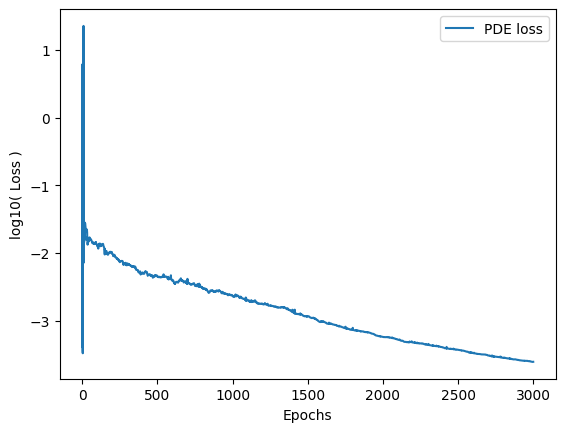

In [6]:
loss_pde_log[0] = np.nan
loss_val_log[0] = np.nan


fig, ax = plt.subplots()
ax.plot(np.log10(loss_pde_log), label="PDE loss")
# ax.plot(loss_val_log, label="Val loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("log10( Loss )")
ax.legend()

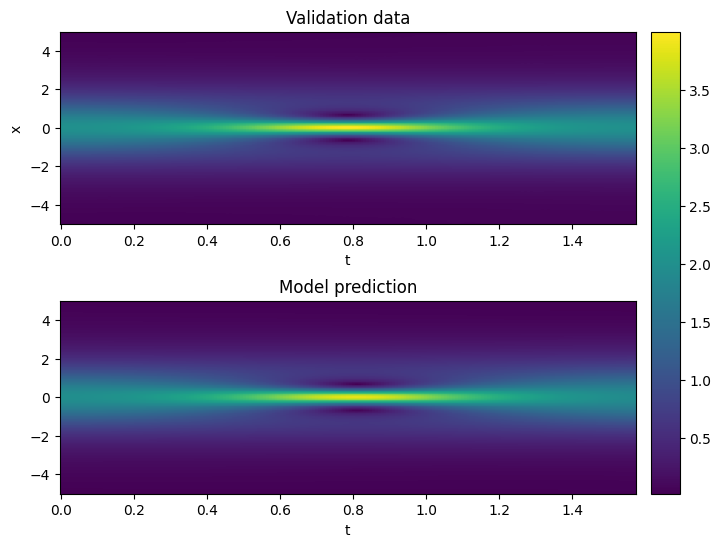

In [7]:
def plot_prediction(model, data_path="data/NLS.mat"):
    model.eval()

    # Load original data
    data = scipy.io.loadmat(data_path)
    x = data["x"].flatten()           # (256,)
    t = data["tt"].flatten()          # (201,)
    X, T = np.meshgrid(x, t, indexing="ij")  # (256, 201)
    h_val = np.sqrt(np.real(data["uu"])**2 + np.imag(data["uu"])**2)

    v_min = np.min(h_val)
    v_max = np.max(h_val)

    XT = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    XT_tensor = torch.tensor(XT, dtype=torch.float32).to(device)

    with torch.no_grad():
        pred = model(XT_tensor)
        u_pred = pred[:, 0].cpu().numpy().reshape(X.shape)
        v_pred = pred[:, 1].cpu().numpy().reshape(X.shape)
        h_pred = np.sqrt(u_pred**2 + v_pred**2)

    fig = plt.figure(figsize=(8, 6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[20, 1], wspace=0.05, hspace=0.4)

    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[1, 0])
    cax = fig.add_subplot(gs[:, 1])  # Colorbar spanning both plots

    im = ax0.pcolormesh(T, X, h_val, shading='auto', cmap='viridis', vmin=v_min, vmax=v_max)
    ax0.set_xlabel('t')
    ax0.set_ylabel('x')
    ax0.set_title('Validation data')

    ax1.pcolormesh(T, X, h_pred, shading='auto', cmap='viridis', vmin=v_min, vmax=v_max)
    ax1.set_xlabel('t')
    ax1.set_title('Model prediction')

    fig.colorbar(im, cax=cax)

    plt.show()



plot_prediction(model)